# Teacher Forcing in RNNs

**Roberto Fierimonte** - 19/02/2018

---

In [1]:
import datetime
import functools
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline 

tfd = tf.contrib.distributions
tfb = tf.contrib.bayesflow

Instructions for updating:
Use the retry module or similar alternatives.


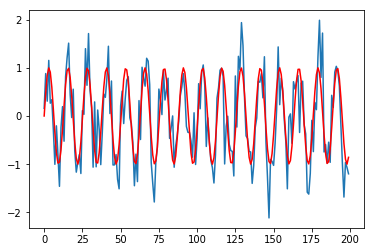

In [2]:
time = np.arange(0, 100, 0.5)
sigma = 0.5
y = np.sin(time)
# y = 0.2 * time + 3 * np.sin(0.5 * time) - 3 * np.cos(1.5 * time)
y_tilde = y[None, :] + sigma * np.random.randn(10, len(time))

plt.plot(y_tilde[0])
plt.plot(y, 'r')
ts = y_tilde[0]

In [3]:
def doublewrap(function):
    """
    A decorator decorator, allowing to use the decorator to be used without
    parentheses if not arguments are provided. All arguments must be optional.
    """
    @functools.wraps(function)
    def decorator(*args, **kwargs):
        if len(args) == 1 and len(kwargs) == 0 and callable(args[0]):
            return function(args[0])
        else:
            return lambda wrapee: function(wrapee, *args, **kwargs)
    return decorator


@doublewrap
def define_scope(function, scope=None, *args, **kwargs):
    """
    A decorator for functions that define TensorFlow operations. The wrapped
    function will only be executed once. Subsequent calls to it will directly
    return the result so that operations are added to the graph only once.
    The operations added by the function live within a tf.variable_scope(). If
    this decorator is used with arguments, they will be forwarded to the
    variable scope. The scope name defaults to the name of the wrapped
    function.
    """
    attribute = '_cache_' + function.__name__
    name = scope or function.__name__
    @property
    @functools.wraps(function)
    def decorator(self):
        if not hasattr(self, attribute):
            with tf.variable_scope(name, *args, **kwargs):
                setattr(self, attribute, function(self))
        return getattr(self, attribute)
    return decorator

# Baseline Model

In [4]:
class LinearCell(tf.contrib.rnn.RNNCell):
    """
    """
    def __init__(self, output_size, state_size, reuse=None):
        super(LinearCell, self).__init__(_reuse=reuse)
        self._output_size = output_size
        self._state_size = state_size
    
    @property
    def state_size(self):
        return self._state_size
    
    @property
    def output_size(self):
        return self._output_size
    
    def call(self, inputs, state):
        state = tf.layers.dense(inputs, self._state_size) + tf.layers.dense(state, self._state_size)
        out = tf.layers.dense(state, self._output_size)
        return out, state

class SimpleSamplingCell(tf.contrib.rnn.RNNCell):
    """
    """
    def __init__(self, cell, output_size, layer, reuse=None):
        super(SimpleSamplingCell, self).__init__(_reuse=reuse)
        self._cell = cell
        self._output_size = output_size
        self._layer = layer

    @property
    def state_size(self):
        return (self._cell.state_size, self._output_size)

    @property
    def output_size(self):
        return (self._output_size)
    
    def call(self, inputs, state_and_sample):
        del inputs  # Unused.
        (state, sample) = state_and_sample
        out, state = self._cell(sample, state)
        sample = self._layer(out)
        return sample, (state, sample)
    
class BaselineModel(object):
    """
    """
    def __init__(self, cell_type='GRU', n_hidden=100):
        self._n_hidden = n_hidden
        self._cell_type = cell_type
        if cell_type == 'Linear':
            self._cell = LinearCell(1, self._n_hidden)
            self._sampling_cell = self._cell
        else:
            self._layer = tf.layers.Dense(1)
            if cell_type == 'GRU':
                self._cell = tf.contrib.rnn.GRUBlockCell(self._n_hidden)
            elif cell_type == 'LSTM':
                self._cell = tf.contrib.rnn.LSTMBlockCell(self._n_hidden)
            elif cell_type == 'RNN':
                self._cell = tf.contrib.rnn.BasicRNNCell(self._n_hidden)
            self._sampling_cell = SimpleSamplingCell(self._cell, 1, self._layer)

    def compute_forward(self, data):
        (out, hidden) = tf.nn.dynamic_rnn(self._cell, inputs=data, dtype=tf.float32)
        if self._cell_type != 'Linear':
            out = self._layer(out)
        return out, hidden    
    
    def pred_forward(self, data, last_training_point, last_hidden):
        inputs = tf.concat([last_training_point[:, None], data], 1)        
        (out, _) = tf.nn.dynamic_rnn(self._cell, inputs=inputs, initial_state=last_hidden, dtype=tf.float32)
        if self._cell_type != 'Linear':
            out = self._layer(out)
        return out
    
    def pred_forward_autoregressive(self, last_training_point, last_hidden, future=500):
        sample = last_training_point
        hidden = last_hidden
        samples = []
        
        for _ in range(future):
            (sample, hidden) = self._cell(sample, hidden)
            if self._cell_type != 'Linear':
                sample = self._layer(sample)
            samples.append(sample)
            
        return tf.transpose(tf.stack(samples, 0), [1,0,2])

In [5]:
tf.reset_default_graph()

seq_length = 150; cell_type = 'Linear'; n_hidden = 10
x_ = tf.placeholder(tf.float32, [None, None, 1])
x_test = tf.placeholder(tf.float32, [None, None, 1])

with tf.variable_scope(cell_type + '_' + str(n_hidden), reuse=tf.AUTO_REUSE) as scope:
    model = BaselineModel(cell_type, n_hidden)
    res, hidden = model.compute_forward(x_[:, :-1])
    loss = tf.reduce_mean(tf.reduce_sum(tf.square(res[..., 0] - x_[:, 1:, 0]), 1))/2
    optimise = tf.train.AdamOptimizer(0.001).minimize(loss)
    
    pred_tf = model.pred_forward(x_test, x_[:, -1], hidden)
    pred_ar_tf = model.pred_forward_autoregressive(x_[:, -1], hidden, future=100)

config = tf.ConfigProto(allow_soft_placement=True)
sess = tf.InteractiveSession(config=config) 
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()
errors_baseline = []; preds_baseline = []; preds_baseline_ar = []; errors_test_baseline = []

timestamp = datetime.datetime.strftime(datetime.datetime.now(), "%Y-%m-%d_%H:%M")

for i in range(10001):
    batch = ts[None, :seq_length+1]
#     batch = np.stack([ts[i:i+seq_length] for i in np.random.randint(0, 150-seq_length, 10)])    
    error = sess.run(loss, {x_: batch[..., None]})
    sess.run(optimise, {x_: batch[..., None]})
    errors_baseline.append(error)
    
    if i % 1000 == 0:
        test_batch = ts[seq_length+1:]
        test_error = sess.run(loss, {x_: test_batch[None, :, None]})
        errors_test_baseline.append(test_error)
        print('Iteration:', i, 'Training Error:', error, 'Test Error:', test_error)
        pred = sess.run(pred_tf, {x_: ts[None, :seq_length+1, None], x_test: ts[None, seq_length+1:, None]})
        pred_ar = sess.run(pred_ar_tf, {x_: ts[None, :seq_length, None]})
        preds_baseline.append(pred); preds_baseline_ar.append(pred_ar)
        
# save_path = saver.save(sess, "/mnt/workspace/baseline_{}_length_{}_iter_{}.ckpt".format(timestamp, seq_length, i))

Iteration: 0 Training Error: 97802264.0 Test Error: 197.88718
Iteration: 1000 Training Error: 1526.9072 Test Error: 31.202974
Iteration: 2000 Training Error: 1096.2676 Test Error: 30.31376
Iteration: 3000 Training Error: 769.66516 Test Error: 29.58387
Iteration: 4000 Training Error: 545.204 Test Error: 29.093758
Iteration: 5000 Training Error: 396.23157 Test Error: 28.790157
Iteration: 6000 Training Error: 302.98932 Test Error: 28.476374
Iteration: 7000 Training Error: 247.15463 Test Error: 27.80332
Iteration: 8000 Training Error: 209.05563 Test Error: 26.441252
Iteration: 9000 Training Error: 175.31169 Test Error: 24.300554
Iteration: 10000 Training Error: 141.636 Test Error: 21.51888


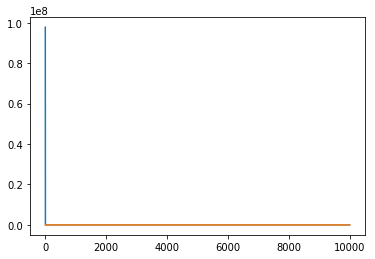

In [6]:
plt.plot(errors_baseline)
plt.plot(range(0, 10001, 1000), errors_test_baseline)

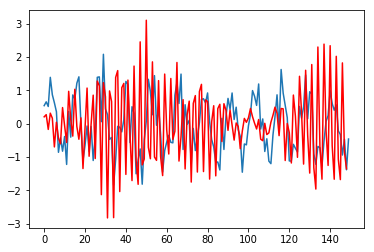

In [7]:
fit = sess.run(res, {x_: ts[None, :150, None]})
plt.plot(ts[None, :150].T)
plt.plot(fit[..., 0].T, 'r')

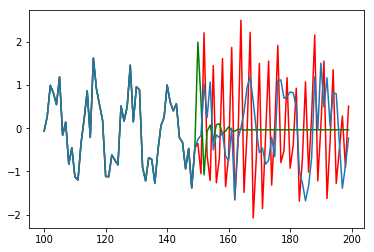

In [8]:
plt.plot(range(100, 200), np.concatenate([ts[None, 100:150, None], pred], 1)[0], 'r')
plt.plot(range(100, 200), np.concatenate([ts[None, 100:150, None], pred_ar[:, :50]], 1)[0], 'g-')
plt.plot(range(100, 200), ts[None, 100:200].T)

In [124]:
A = sess.run(gen_model._cell._A)
B = sess.run(gen_model._cell._B)
c = sess.run(gen_model._cell._c)
D = sess.run(gen_model._cell._D)
e = sess.run(gen_model._cell._e)

sigma_c = gen_stddevs[-1][None, None]
sigma_b = stds[-1][None, None]

h = np.zeros((batch_size, 2))
y = np.zeros((batch_size, 1))

means_h = [h]
means_y = [y]
sigmas_h = [0]
sigmas_y = [sigma_b**2 + sigma_c**2]

for t in range(seq_length):
    mu_h = np.matmul(means_h[-1], A) + np.matmul(means_y[-1], B) + c
    mu_y = np.matmul(mu_h, D) + e + y_tilde[0, t]
    means_h.append(mu_h); means_y.append(mu_y)

for t in range(1, seq_length):
    sigma_h = (t-1) * np.matmul(B.T, np.matmul(sigma_b ** 2, B))
    sigma_y = sigma_c ** 2 + sigma_b ** 2
    sigmas_h.append(sigma_h)

# Our Model

In [4]:
class LinearMarkovianCellWithState(tf.contrib.rnn.RNNCell):
    """
    """
    def __init__(self, event_size, state_size, reuse=None):
        super(LinearMarkovianCellWithState, self).__init__(_reuse=reuse)
        self._state_size = state_size
        self._event_size = event_size
        self._A = tf.get_variable('A', shape=(state_size, state_size), dtype=tf.float32)
        self._B = tf.get_variable('B', shape=(event_size, state_size), dtype=tf.float32)
        self._c = tf.get_variable('c', shape=(state_size,), dtype=tf.float32)
        self._D = tf.get_variable('D', shape=(state_size, event_size), dtype=tf.float32)
        self._e = tf.get_variable('e', shape=(event_size,), dtype=tf.float32)
        self._std = tf.nn.softplus(tf.get_variable('cell_std', shape=(1, 1),
                                   initializer=tf.constant_initializer(0.5)))
        
    @property
    def state_size(self):
        return self._state_size

    @property
    def output_size(self):
        return (self._event_size, self._event_size)

    def call(self, inputs, state):
        state = tf.matmul(state, self._A)  + tf.matmul(inputs, self._B) + self._c
        mean = tf.matmul(state, self._D) + self._e
        return (mean, tf.tile(self._std, [inputs.shape[0], 1])), state

class SamplingCell(tf.contrib.rnn.RNNCell):
    """
    RNN cell that produce a sequence in autoregressive mode by sampling at
    each step
    """

    def __init__(self, cell, output_size, n_samples=1, reuse=None):
        super(SamplingCell, self).__init__(_reuse=reuse)
        self._cell = cell
        self._output_size = output_size
        self._n_samples = n_samples

    @property
    def state_size(self):
        return (self._cell.state_size, self._output_size)

    @property
    def output_size(self):
        return (self._output_size, self._output_size)

    def call(self, _ , state_and_sample):
        (state, sample) = state_and_sample
        (mean, std), state = self._cell(sample, state)
        sample = tfd.Normal(mean, std).sample()
        return (mean, std), (state, sample)
    
class RobustARGenerator(object):
    """
    Model to test
    """
    def __init__(self, data, n_hidden=100, n_samples=200, seq_length=1000, batch_size=1):
        self._data = data
        self._n_hidden = n_hidden
        self._batch_size = batch_size
        self._n_samples = n_samples
        self._seq_length = seq_length
        self._cell = LinearMarkovianCellWithState(1, self._n_hidden)
        self._sampling_cell = SamplingCell(self._cell, 1, self._n_samples)
        
        self._optimiser = tf.train.AdamOptimizer(0.001)
        self._gen_stddev = tf.get_variable('generative_std', shape=(), trainable=False, 
                                           initializer=tf.constant_initializer(0.5))
        self.make_posterior
        self.compute_elbo_david
        self.E_step
        self.M_step
    
    @define_scope
    def make_posterior(self):
        means = tf.Variable(initial_value=tf.zeros((1, seq_length)), name='post_means', dtype=tf.float32)
        self._post_stddev = tf.nn.softplus(tf.get_variable(shape=(), initializer=tf.constant_initializer(1), 
                                                           name='post_std'))
        return tfd.Independent(tfd.MultivariateNormalDiag(means, scale_identity_multiplier=self._post_stddev))
        
    @define_scope
    def make_transitional(self):
        inputs = tf.concat([tf.zeros((self._batch_size * self._n_samples, 1, 1)), self._code[:, :-1]], 1)
        (means, _), _ = tf.nn.dynamic_rnn(self._cell, inputs=inputs, dtype=tf.float32)
        return means
    
    @define_scope
    def compute_elbo_david(self):      
        posterior = self.make_posterior
        code = tf.transpose(posterior.sample((self._batch_size * self._n_samples)), [0, 2, 1])
        self._code = tf.reshape(code, [-1, self._seq_length, 1])
        
        entropy = self._seq_length * tf.log(tf.square(self._post_stddev))
        means = self.make_transitional

        exponent_trans = tf.square(self._code[..., 0] - means[..., 0])/tf.square(self.trans_std)
        normaliser_trans = self._seq_length * tf.log(tf.square(self.trans_std))
        kl = - entropy + normaliser_trans + tf.reduce_mean(tf.reduce_sum(exponent_trans, -1))
        
        code2 = tf.tile(tf.transpose(code, [0,2,1]), [1, self._batch_size, 1])
        exp1 = tf.reduce_mean(tf.reduce_sum(tf.square(code2 - self._data[None, ..., 0]), -1))

        exponent_gen = exp1/tf.square(self._gen_stddev) 
        reconstruction = - exponent_gen - self._seq_length * tf.log(tf.square(self._gen_stddev))
        
        return reconstruction - kl, kl, reconstruction, entropy   
    
    @define_scope
    def E_step(self):
        post_var = [v for v in tf.trainable_variables() if v.name.startswith('make_posterior/')]
        return self._optimiser.minimize(-self.compute_elbo_david[0], var_list=post_var)
    
    @define_scope
    def M_step(self):
        non_post_var = [v for v in tf.trainable_variables() if not v.name.startswith('make_posterior/')]
        return self._optimiser.minimize(-self.compute_elbo_david[0], var_list=non_post_var)
    
    @define_scope
    def trans_std(self):
        return tf.squeeze(self._cell._std)
    
    @define_scope
    def gen_std(self):
        return self._gen_stddev 
    
#     @define_scope
#     def make_forward_posterior(self):
#         y_mu = tf.Variable(tf.zeros(), name='forward_y_mean', dtype=tf.float32)
#         y_sigma = tf.nn.softplus(tf.get_variable(shape=(), initializer=tf.constant_initializer(2), 
#                                                  name='forward_y_std'))
#         y_dist = tfd.Normal(y_mu, y_sigma)
        
#         h_mu = tf.Variable(tf.zeros(self._n_hidden), name='forward_h_mean', dtype=tf.float32)
#         h_sigma = tf.nn.softplus(tf.get_variable(shape=(self._n_hidden), initializer=tf.constant_initializer(2), 
#                                                  name='forward_h_std'))
#         h_dist = tfd.MultivariateNormalDiag(h_mu, scale_diag=h_sigma)
        
#         return y_dist, h_dist
    
#     @define_scope
#     def make_forward_parameters(self):
#         return tf.Variable(tf.zeros(50), name='best_forward_sequence', dtype=tf.float32)
    
#     @define_scope
#     def compute_forward_message(self):
#         code = tf.reshape(self._code, [self._n_samples, self._batch_size, self._seq_length])[:, 0, None, :]        
#         hT = tf.nn.dynamic_rnn(self._cell, inputs=code, dtype=tf.float32)
#         dist_y = tfd.Normal(self.make_posterior.mean()[:, -1], self._post_stddev)
#         return dist_y, hT
    
#     @define_scope
#     def forward_E_step(self):
#         post_var = [v for v in tf.trainable_variables() if v.name.startswith('compute_elbo_forward')]
#         return self._optimiser.minimize(-self.compute_elbo_forward, var_list=post_var)
    
#     @define_scope
#     def forward_M_step(self):
#         post_var = [v for v in tf.trainable_variables() if v.name.startswith('compute_elbo_forward')]
#         return self._optimiser.minimize(-self.compute_elbo_forward, var_list=post_var)
    
#     @define_scope
#     def compute_elbo_forward(self):
#         posterior_y, posterior_h = self.make_forward_posterior
#         pred = self.make_forward_parameters
        
#         covariance_h = posterior_h.scale @ posterior_h.scale.T
#         entropy = tf.log(tf.square(posterior_y.scale)) + tf.linalg.logdet(covariance_h)
        
#         means = tf.nn.dynamic_rnn(self._sampling_cell)
#         reconstruction = 

In [ ]:
tf.reset_default_graph()

seq_length = 150; n_samples = 200; batch_size = 10;
data = np.tile(y_tilde[:batch_size, :seq_length], (n_samples, 1))
x_ = tf.placeholder(tf.float32, [batch_size, seq_length, 1])

gen_model = RobustARGenerator(x_, n_hidden=2, n_samples=n_samples, seq_length=seq_length, batch_size=batch_size)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
# tf.train.Saver().restore(sess, "/Users/robertofiermonte/Repository/model_{}.ckpt".format(batch_size))

elbos = []; kls = []; llks = []; test_elbos = []; preds = []; preds_greedy = []
means = []; stds = []; gen_stddevs = []; post_stddevs = []; post_samples = []; post_means = []
    
for i in range(25001):
    batch = data[:batch_size]
#     batch = ts[:seq_length][None, ...]
    elbo, kl, llk, entropy = sess.run(gen_model.compute_elbo_david, {x_: batch[..., None]})
    elbos.append(elbo); kls.append(kl); llks.append(llk)
    post_means.append(sess.run(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'make_posterior/post_means:0'))[0])
    post_stddevs.append(sess.run(gen_model._post_stddev))
    m = sess.run(gen_model.make_transitional, {x_: batch[..., None]})
    s = sess.run(gen_model.trans_std, {x_: batch[..., None]})
    means.append(m); stds.append(s); gen_stddevs.append(sess.run(gen_model.gen_std, {x_: batch[..., None]}))
    latents = sess.run(gen_model._code, {x_: batch[..., None]})
    post_samples.append(latents)
    
    if i % 1000 == 0:
        print('Iteration:', i, 'ELBO:', elbo, 'KL:', kl, 'Reconstruction:', llk, 'Entropy:', entropy)
    
    sess.run(gen_model.E_step, {x_: batch[..., None]})
    sess.run(gen_model.M_step, {x_: batch[..., None]})

# tf.train.Saver().save(sess, '/Users/robertofiermonte/Repository/model_{}.ckpt'.format(batch_size))

# for i in range(15001):   
#     elbo_forward = sess.run(gen_model.compute_elbo_forward, {x_: batch[..., None]})
#     sess.run(gen_model.forward_E_step, {x_: batch[..., None]})
    
#     if i % 1000 == 0:
#         print('Iteration:', i, 'ELBO Forward:', elbo_forward)

Iteration: 0 ELBO: -3871.2087 KL: 2577.138 Reconstruction: -1294.0708 Entropy: 81.75415
Iteration: 1000 ELBO: -563.7705 KL: 229.7735 Reconstruction: -333.997 Entropy: -75.57278
Iteration: 2000 ELBO: -404.84665 KL: 265.1046 Reconstruction: -139.74203 Entropy: -173.8612
Iteration: 3000 ELBO: -352.35864 KL: 265.50336 Reconstruction: -86.855286 Entropy: -236.6816
Iteration: 4000 ELBO: -183.02652 KL: 172.95958 Reconstruction: -10.06694 Entropy: -321.2049
Iteration: 5000 ELBO: -138.5612 KL: 159.13553 Reconstruction: 20.574326 Entropy: -422.62326
Iteration: 6000 ELBO: -117.994354 KL: 152.34033 Reconstruction: 34.345978 Entropy: -513.317
Iteration: 7000 ELBO: -109.93237 KL: 151.12871 Reconstruction: 41.196335 Entropy: -597.10297
Iteration: 8000 ELBO: -106.27113 KL: 150.9448 Reconstruction: 44.67366 Entropy: -675.8326
Iteration: 9000 ELBO: -103.63301 KL: 150.28917 Reconstruction: 46.65616 Entropy: -749.76984
Iteration: 10000 ELBO: -103.565384 KL: 151.29652 Reconstruction: 47.73114 Entropy: -817

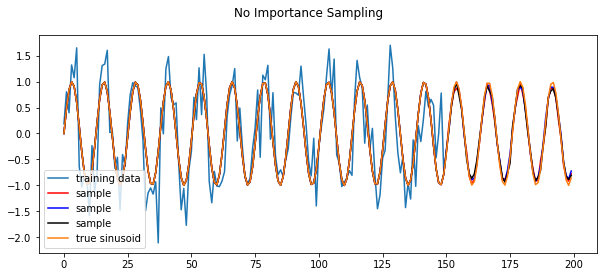

In [475]:
code = sess.run(gen_model._forward_code, {x_: batch[..., None]})
fig, axs = plt.subplots(1,1,figsize=(10, 4))
plt.plot(y_tilde[0, :seq_length], label='training data')
plt.plot(np.concatenate([y[:seq_length, None], code[1, 1:]], 0), 'r', label='sample')
plt.plot(np.concatenate([y[:seq_length, None], code[0, 1:]], 0), 'b', label='sample')
plt.plot(np.concatenate([y[:seq_length, None], code[2, 1:]], 0), 'k', label='sample')
plt.plot(y[:seq_length+50, None], label='true sinusoid')
plt.legend();
plt.suptitle('No Importance Sampling');

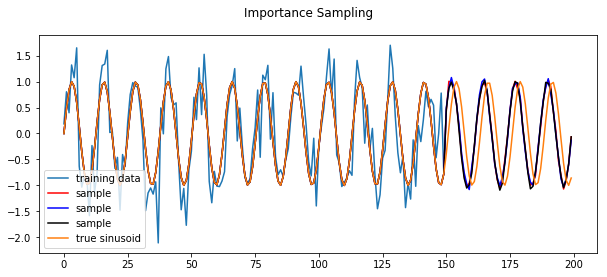

In [474]:
# code = sess.run(gen_model._forward_code, {x_: batch[..., None]})
fig, axs = plt.subplots(1,1,figsize=(10, 4))
plt.plot(y_tilde[0, :seq_length], label='training data')
plt.plot(np.concatenate([y[:seq_length, None], code[1, 1:]], 0), 'r', label='sample')
plt.plot(np.concatenate([y[:seq_length, None], code[0, 1:]], 0), 'b', label='sample')
plt.plot(np.concatenate([y[:seq_length, None], code[2, 1:]], 0), 'k', label='sample')
plt.plot(y[:seq_length+50, None], label='true sinusoid')
plt.legend();
plt.suptitle('Importance Sampling');

In [ ]:
plt.plot(np.squeeze(np.array(post_stddevs))[1000:], label='post sigma')
plt.plot(gen_stddevs[1000:], label='gen sigma')
plt.plot([np.mean(s) for s in stds][1000:], label='trans. sigmas')
plt.legend();

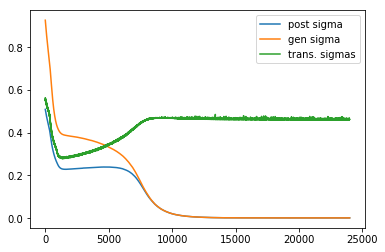

In [28]:
plt.plot(np.squeeze(np.array(post_stddevs))[1000:], label='post sigma')
plt.plot(gen_stddevs[1000:], label='gen sigma')
plt.plot([np.mean(s) for s in stds][1000:], label='trans. sigmas')
plt.legend();

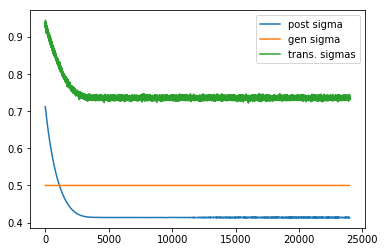

In [344]:
plt.plot(np.squeeze(np.array(post_stddevs))[1000:], label='post sigma')
plt.plot(gen_stddevs[1000:], label='gen sigma')
plt.plot([np.mean(s) for s in stds][1000:], label='trans. sigmas')
plt.legend();

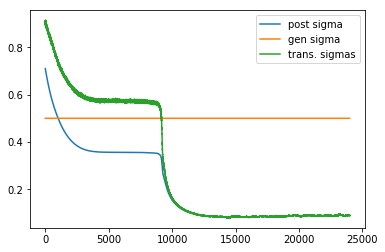

In [32]:
plt.plot(np.squeeze(np.array(post_stddevs))[1000:], label='post sigma')
plt.plot(gen_stddevs[1000:], label='gen sigma')
plt.plot([np.mean(s) for s in stds][1000:], label='trans. sigmas')
plt.legend();

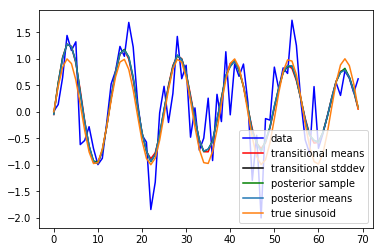

In [57]:
# plt.plot(ts[:70], 'b', label='data')
plt.plot(np.mean(means[-1], 0), 'r-', label='transitional means')
# plt.plot(stds[-1], 'k', label='transitional stddev')
plt.plot(np.mean(np.stack(latents, 0), 0), 'g', label='posterior sample')
plt.plot(np.mean(sess.run(gen_model.make_posterior.mean() , {x_: batch[..., None]}), 0), label='posterior means')
# plt.plot(y[:70], label='true sinusoid')
plt.legend();

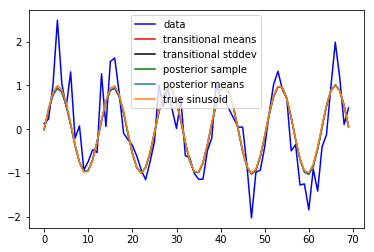

In [13]:
plt.plot(ts[:70], 'b', label='data')
plt.plot(np.mean(means[-1], 0), 'r-', label='transitional means')
plt.plot(stds[-1], 'k', label='transitional stddev')
plt.plot(np.mean(np.stack(latents, 0), 0), 'g', label='posterior sample')
plt.plot(np.mean(sess.run(gen_model.make_posterior.mean() , {x_: batch[..., None]}), 0), label='posterior means')
plt.plot(y[:70], label='true sinusoid')
plt.legend();

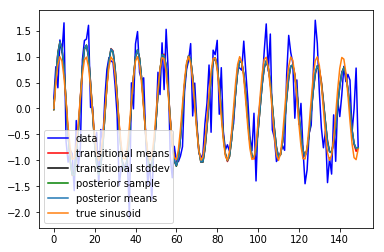

In [478]:
plt.plot(ts[:seq_length], 'b', label='data')
plt.plot(np.mean(means[-1], 0), 'r-', label='transitional means')
plt.plot(stds[-1], 'k', label='transitional stddev')
plt.plot(np.mean(np.stack(latents, 0), 0), 'g', label='posterior sample')
plt.plot(np.mean(sess.run(gen_model.make_posterior.mean() , {x_: batch[..., None]}), 0), label='posterior means')
plt.plot(y[:seq_length], label='true sinusoid')
plt.legend();

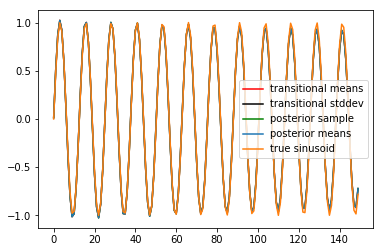

In [371]:
# plt.plot(ts[:seq_length], 'b', label='data')
plt.plot(np.mean(means[-1], 0), 'r-', label='transitional means')
plt.plot(stds[-1], 'k', label='transitional stddev')
plt.plot(np.mean(np.stack(latents, 0), 0), 'g', label='posterior sample')
plt.plot(np.mean(sess.run(gen_model.make_posterior.mean() , {x_: batch[..., None]}), 0), label='posterior means')
plt.plot(y[:seq_length], label='true sinusoid')
plt.legend();

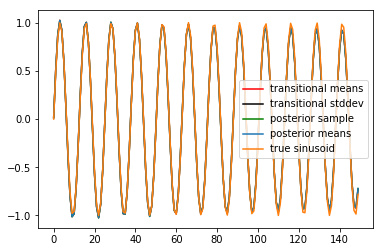

In [247]:
# plt.plot(ts[:seq_length], 'b', label='data')
plt.plot(np.mean(means[-1], 0), 'r-', label='transitional means')
plt.plot(stds[-1], 'k', label='transitional stddev')
plt.plot(np.mean(np.stack(latents, 0), 0), 'g', label='posterior sample')
plt.plot(np.mean(sess.run(gen_model.make_posterior.mean() , {x_: batch[..., None]}), 0), label='posterior means')
plt.plot(y[:seq_length], label='true sinusoid')
plt.legend();

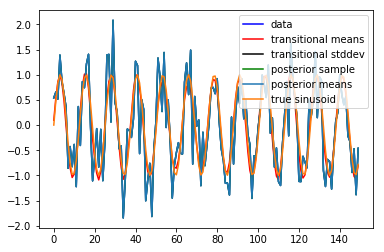

In [29]:
plt.plot(ts[:seq_length], 'b', label='data')
plt.plot(np.mean(means[-1], 0), 'r-', label='transitional means')
plt.plot(stds[-1], 'k', label='transitional stddev')
plt.plot(np.mean(np.stack(latents, 0), 0), 'g', label='posterior sample')
plt.plot(np.mean(sess.run(gen_model.make_posterior.mean() , {x_: batch[..., None]}), 0), label='posterior means')
plt.plot(y[:seq_length], label='true sinusoid')
plt.legend();

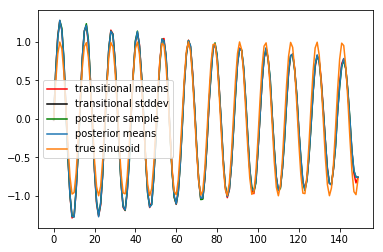

In [238]:
# plt.plot(ts[:seq_length], 'b', label='data')
plt.plot(np.mean(means[-1], 0), 'r-', label='transitional means')
plt.plot(stds[-1], 'k', label='transitional stddev')
plt.plot(np.mean(np.stack(latents, 0), 0), 'g', label='posterior sample')
plt.plot(np.mean(sess.run(gen_model.make_posterior.mean() , {x_: batch[..., None]}), 0), label='posterior means')
plt.plot(y[:seq_length], label='true sinusoid')
plt.legend();

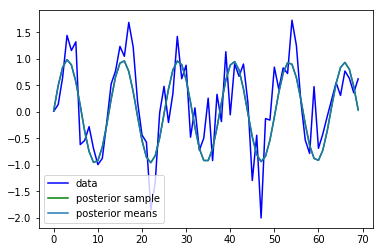

In [27]:
plt.plot(ts[:70], 'b', label='data')
plt.plot(np.mean(means[-1], 0), 'r-', label='transitional means')
plt.plot(stds[-1], 'k', label='transitional stddev')
plt.plot(np.mean(np.stack(latents, 0), 0), 'g', label='posterior sample')
plt.plot(np.mean(sess.run(gen_model.make_posterior.mean() , {x_: batch[..., None]}), 0), label='posterior means')
plt.plot(y[:70], label='true sinusoid')
plt.legend();

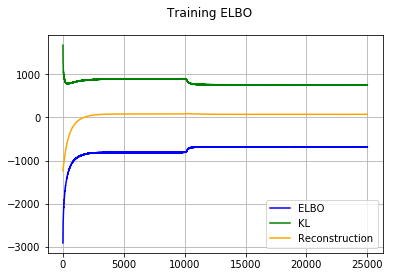

In [33]:
plt.plot(elbos, 'b', label='ELBO')
plt.plot(kls, 'g', label='KL')
plt.plot(llks, 'orange', label='Reconstruction')
plt.suptitle('Training ELBO')
plt.grid("on")
plt.legend()
plt.show()

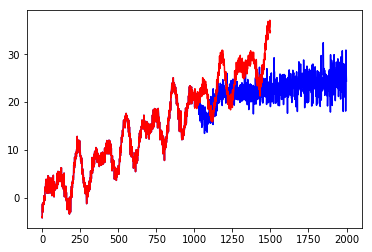

In [0]:
pred = sess.run(model.predict_forward, {x_: ts[:seq_length, None].T})
for i in range(1):
    plt.plot(np.concatenate([ts[:seq_length], pred[i]]), 'b')
plt.plot(np.concatenate([ts[:seq_length], ts[seq_length:seq_length+500]]), 'r')

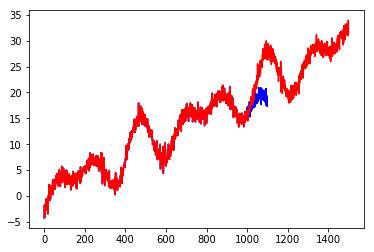

In [0]:
pred = sess.run(model.predict_forward, {x_: ts[:seq_length, None].T})
for i in range(1):
    plt.plot(np.concatenate([ts[:seq_length], pred[i][:500]]), 'b')
plt.plot(np.concatenate([ts[:seq_length], ts[seq_length:seq_length+500]]), 'r')

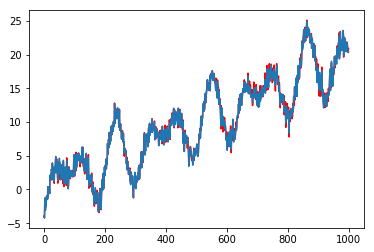

In [0]:
m, s = sess.run(model.make_transitional, {x_: ts[:seq_length, None].T})
plt.plot(ts[:seq_length], 'r')
plt.plot(m[0, :, 0])

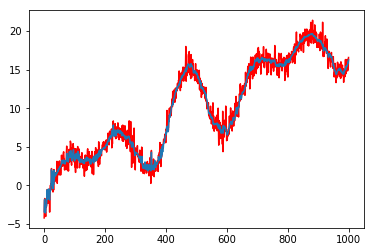

In [0]:
m, s = sess.run(model.make_transitional, {x_: ts[:seq_length, None].T})
plt.plot(ts[:seq_length], 'r')
plt.plot(m[0, :, 0])

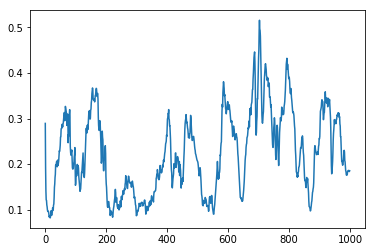

In [0]:
plt.plot(s[0, :, 0])

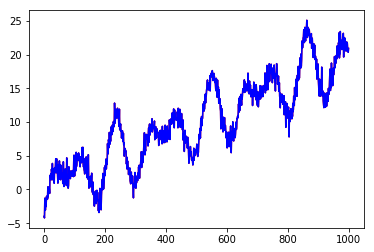

In [0]:
plt.plot(ts[:seq_length], 'r', test_latents[0, :, 0], 'b')

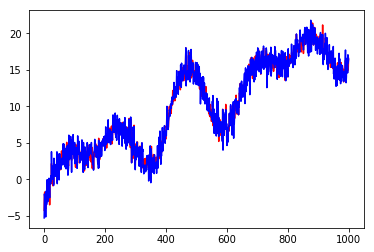

In [0]:
plt.plot(ts[:seq_length], 'r', test_latents[0, :, 0], 'b')